In [1]:
from typing import List, Tuple, Union
import argparse
import json
from math import sqrt, ceil
import numpy as np
import matplotlib.pyplot as plt
import cirq
import openfermion as of
import qiskit
from qiskit.circuit.library import PauliEvolutionGate, phase_estimation
from qiskit.synthesis import LieTrotter
from qiskit import transpile
import quimb.tensor as qtn
from quimb.tensor.tensor_1d import MatrixProductState
from tensor_network_common import pauli_sum_to_mpo, pauli_string_to_mpo, mps_to_vector
from convert import cirq_pauli_sum_to_qiskit_pauli_op
from kcommute import commutes
from qpe_trotter import (
    group_single_strings,
    # trotter_perturbation,
    bits_for_epsilon,
    get_gate_counts
)

In [2]:
def trotter_perturbation(hamiltonian_terms: List[cirq.PauliSum]) -> cirq.PauliSum:
    """Get the first order of the perturbation Hamiltonian in Eqn. 7 of Mehendale et al.
    Note that this does not include the factor of dt^2.
    
    Arguments:
    hamiltonian_terms - The terms {H_1, ..., H_n} used in the Trotter decomposition.
    
    Returns:
    H' - The perturbation to the Hamiltonian to second order in dt."""

    M = len(hamiltonian_terms)
    # print(f"M = {M}")
    h_prime = cirq.PauliSum()
    # TODO Can I parallelize this? Maybe only over the mu loop.
    for mu in range(2 * M - 1):
        if mu >= M:
            i = mu - M
            h_mu = hamiltonian_terms[M - 1 - i]
        else:
            h_mu = hamiltonian_terms[mu]
        for nu in range(mu+1, 2 * M):
            if nu >= M:
                i = nu - M
                h_nu = hamiltonian_terms[M - 1 - i]
            else:
                h_nu = hamiltonian_terms[nu]
            comm_nu_mu = h_nu * h_mu - h_mu * h_nu
            for nu_prime in range(nu, 2 * M):
                print(f"mu = {mu} nu = {nu} nu_prime = {nu_prime}")
                if nu_prime >= M:
                    i = nu_prime - M
                    h_nu_prime = hamiltonian_terms[M - 1 - i]
                else:
                    h_nu_prime = hamiltonian_terms[nu_prime]
                comm_three = h_nu_prime * comm_nu_mu - comm_nu_mu * h_nu_prime
                if nu_prime == nu:
                    delta = 1.
                else:
                    delta = 0.
                # print(mu, nu, nu_prime)
                # print(1 - delta / 2)
                # print(comm_three)
                h_prime += (1. - delta / 2.) * comm_three
    return -1. / 24. * h_prime

In [8]:
def num_summands(m: int) -> float:
    """Get the number of terms in the summation."""

    total = 0.
    for mu in range(1, 2 * m):
        nu_sum = -0.5 * (mu - 2 * m) * (2 * m + 1 + mu)
        total += float(2 * m + 1) * (2 * m - mu) - nu_sum
    return total


def sample_eps2(
    hamiltonian: cirq.PauliSum, qs: List[cirq.Qid], ground_state: Union[np.ndarray, MatrixProductState],
    samples: int, interval: int=10, max_mpo_bond: int=100
) -> Tuple[List[int], List[float], int]:
    """Estimate eps2 by sampling terms uniformly."""

    hamiltonian_terms = [ps for ps in hamiltonian]
    M = len(hamiltonian_terms)
    # num_sum = num_summands(M)
    # print(f"{num_sum} terms in summation.")
    sample_checkpoints = []
    sample_num_checkpoints = []
    num_zero = 0
    running_estimate = 0.
    v2 = cirq.PauliSum()
    for n in range(samples):
        mu = np.random.randint(0, 2 * M - 1)
        nu = np.random.randint(mu + 1, 2 * M)
        nu_prime = np.random.randint(nu, 2 * M)
        p_mu = 1. / len(range(0, 2 * M - 1))
        p_nu = 1. / len(range(mu + 1, 2 * M))
        p_nu_prime = 1. / len(range(nu, 2 * M))
        p = p_mu * p_nu * p_nu_prime
        if mu >= M:
            i = mu - M
            h_mu = hamiltonian_terms[M - 1 - i]
        else:
            h_mu = hamiltonian_terms[mu]
        if nu >= M:
            i = nu - M
            h_nu = hamiltonian_terms[M - 1 - i]
        else:
            h_nu = hamiltonian_terms[nu]
        if nu_prime >= M:
            i = nu_prime - M
            h_nu_prime = hamiltonian_terms[M - 1 - i]
        else:
            h_nu_prime = hamiltonian_terms[nu_prime]
        if nu_prime == nu:
            delta = 1.
        else:
            delta = 0.
        # if not commutes(h_nu, h_mu, blocks):
        #     comm_nu_mu = 2. * h_nu * h_mu # = [H_nu, H_mu] when they anti-commute.
        #     if not commutes(h_nu_prime, comm_nu_mu, blocks):
        #         # This term contributes.
        #         comm_three = 2. * h_nu_prime * comm_nu_mu
        #         comm_three_mpo = pauli_string_to_mpo(comm_three, qs)
        #         mat_elem = ground_state.H @ comm_three_mpo.apply(ground_state)
        #         running_estimate += (1 - delta / 2) * mat_elem.real * num_sum
        #     else:
        #         num_zero += 1
        comm_nu_mu = h_nu * h_mu - h_mu * h_nu
        comm_three = h_nu_prime * comm_nu_mu - comm_nu_mu * h_nu_prime
        # print(mu, nu, nu_prime)
        # print(f"p = {p}")
        # print(1 - delta / 2)
        # print(comm_three)
        if len(comm_three) != 0:
            if isinstance(ground_state, MatrixProductState):
                comm_three_mpo = pauli_sum_to_mpo(comm_three, qs, max_mpo_bond)
                mat_elem = ground_state.H @ comm_three_mpo.apply(ground_state)
                running_estimate += (1 - delta / 2) * mat_elem.real / p
            else:
                qubit_map = {q: i for i, q in enumerate(qs)}
                mat_elem = comm_three.expectation_from_state_vector(ground_state, qubit_map)
                running_estimate += (1 - delta / 2) * mat_elem.real / p
            # v2 += (-1 / 24.) * (1 - delta / 2) * comm_three / p
        else:
            num_zero += 1
        if n % interval == 0 or n == samples - 1:
            sample_checkpoints.append((-1 / 24.) * running_estimate / float(n + 1))
            sample_num_checkpoints.append(n+1)
            # print("v2 =", v2 / float(n+1))
    return sample_num_checkpoints, sample_checkpoints, num_zero

## Simple model

In [9]:
nq = 1
psi = np.zeros(2 ** nq, dtype=complex)
psi[0] = 1 / sqrt(2)
psi[1] = -1 / sqrt(2)
print(psi)
psi_mps = MatrixProductState.from_dense(psi)

qs = cirq.LineQubit.range(nq)
ham = cirq.PauliSum()
for i in range(nq):
    ham += 1.0 * cirq.Z.on(qs[i]) + 1.0 * cirq.X.on(qs[i])

[ 0.70710678+0.j -0.70710678+0.j]


In [10]:
max_mpo_bond = 100
groups = [ps for ps in ham]
v2 = trotter_perturbation(groups)
print("v2 =", v2)
v2_mpo = pauli_sum_to_mpo(v2, qs, max_mpo_bond)
# Get energy from Mehendale Eqn. 8
eps2_exact = (psi_mps.H @ v2_mpo.apply(psi_mps)).real

qubit_map = {q: i for i, q in enumerate(qs)}
eps2_statevector = v2.expectation_from_state_vector(psi, qubit_map)

print(f"eps2 = {eps2_exact}")
print(f"eps2 from statevector = {eps2_statevector}")

mu = 0 nu = 1 nu_prime = 1
mu = 0 nu = 1 nu_prime = 2
mu = 0 nu = 1 nu_prime = 3
mu = 0 nu = 2 nu_prime = 2
mu = 0 nu = 2 nu_prime = 3
mu = 0 nu = 3 nu_prime = 3
mu = 1 nu = 2 nu_prime = 2
mu = 1 nu = 2 nu_prime = 3
mu = 1 nu = 3 nu_prime = 3
mu = 2 nu = 3 nu_prime = 3
v2 = -0.333*Z(q(0))+0.167*X(q(0))
eps2 = 9.149958124033984e-19
eps2 from statevector = (-0.16666666666666663+0j)


In [15]:
samples = 1_000
blocks = [qs]
num_samples, eps2_sampled, _ = sample_eps2(ham, qs, psi, samples)
print("Sampled eps2 =", eps2_sampled[-1])

Sampled eps2 = -0.17774999999999994


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


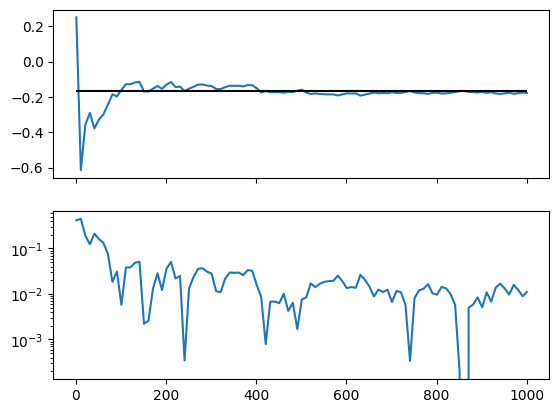

In [16]:
sample_error = np.abs(np.array(eps2_sampled) - eps2_statevector)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(num_samples, eps2_sampled)
ax[0].hlines(eps2_statevector, 0., max(num_samples), colors="k")
ax[1].plot(num_samples, sample_error)
ax[1].set_yscale("log")

## Hubbard

In [17]:
l = 3
t = 1.0
u = 4.0
max_mpo_bond = 100
max_mps_bond = 15
evol_time = 0.1
energy_error = 1e-3

ham = of.fermi_hubbard(l, l, t, u, spinless=True)
ham_jw = of.transforms.jordan_wigner(ham)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
blocks = [qs]
nq = len(qs)
print(f"Hamiltonian has {nq} qubits.")
ham_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(ham_cirq)
ham_mpo = pauli_sum_to_mpo(ham_cirq, qs, max_mpo_bond)

Hamiltonian has 64 terms.
Hamiltonian has 9 qubits.


In [18]:
# Get an approximate ground state using DMRG.
dmrg = qtn.tensor_dmrg.DMRG(ham_mpo, max_mps_bond)
converged = dmrg.solve()
if not converged:
    print("DMRG did not converge!")
ground_state = dmrg.state
ground_energy = dmrg.energy.real
print(f"Final DMRG energy: {ground_energy:4.5e}")

Final DMRG energy: -4.12311e+00


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: divide by zero encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: overflow encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in matmul
  return func(*args, **kwargs)


In [19]:
# Use the exact method.
groups = group_single_strings(ham_cirq)
v2 = trotter_perturbation(groups)
v2_mpo = pauli_sum_to_mpo(v2, qs, max_mpo_bond)
# Get energy from Mehendale Eqn. 8
eps2 = (ground_state.H @ v2_mpo.apply(ground_state)).real
print(f"eps2 = {eps2:4.5e}")
dt = sqrt(energy_error / eps2)
num_steps = ceil(evol_time / dt)
print(f"dt = {dt:4.5e}, n_steps = {num_steps}")


mu = 0
mu = 1
mu = 2
mu = 3
mu = 4
mu = 5
mu = 6
mu = 7
mu = 8
mu = 9
mu = 10
mu = 11
mu = 12
mu = 13
mu = 14
mu = 15
mu = 16
mu = 17
mu = 18
mu = 19
mu = 20
mu = 21
mu = 22
mu = 23
mu = 24
mu = 25
mu = 26
mu = 27
mu = 28
mu = 29
mu = 30
mu = 31
mu = 32
mu = 33
mu = 34
mu = 35
mu = 36
mu = 37
mu = 38
mu = 39
mu = 40
mu = 41
mu = 42
mu = 43
mu = 44
mu = 45
mu = 46
mu = 47
mu = 48
mu = 49
mu = 50
mu = 51
mu = 52
mu = 53
mu = 54
mu = 55
mu = 56
mu = 57
mu = 58
mu = 59
mu = 60
mu = 61
mu = 62
mu = 63
mu = 64
mu = 65
mu = 66
mu = 67
mu = 68
mu = 69
mu = 70
mu = 71
mu = 72
mu = 73
mu = 74
mu = 75
mu = 76
mu = 77
mu = 78
mu = 79
mu = 80
mu = 81
mu = 82
mu = 83
mu = 84
mu = 85
mu = 86
mu = 87
mu = 88
mu = 89
mu = 90
mu = 91
mu = 92
mu = 93
mu = 94
mu = 95
mu = 96
mu = 97
mu = 98
mu = 99
mu = 100
mu = 101
mu = 102
mu = 103
mu = 104
mu = 105
mu = 106
mu = 107
mu = 108
mu = 109
mu = 110
mu = 111
mu = 112
mu = 113
mu = 114
mu = 115
mu = 116
mu = 117
mu = 118
mu = 119
mu = 120
mu = 121
mu = 122
mu 

/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: divide by zero encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: overflow encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in matmul
  return func(*args, **kwargs)


In [20]:
samples = 1_000_000
reps = 10
all_samples = []
for _ in range(reps):
    sample_nums, eps2_sampled, _ = sample_eps2(ham_cirq, blocks, ground_state, samples)
    all_samples.append(eps2_sampled)
all_samples = np.array(all_samples)

In [21]:
eps2_average = np.average(all_samples, axis=0)
eps2_std = np.std(all_samples, axis=0)

print(eps2_average[-1])
print(eps2_std[-1])

3.4437573414392446
10.088551893753387


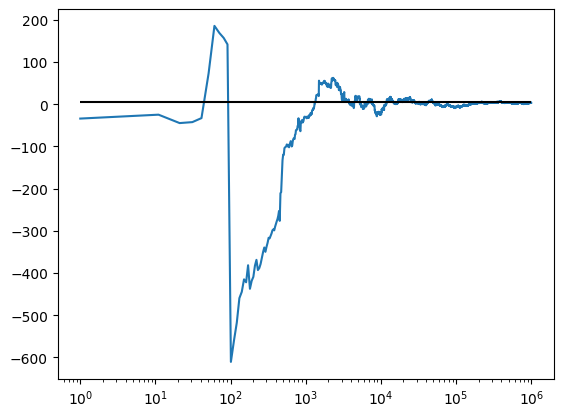

In [22]:
fig, ax = plt.subplots()
ax.plot(sample_nums, eps2_average)
ax.hlines(eps2, np.min(sample_nums), np.max(sample_nums), color="k")
ax.set_xscale("log")